In [31]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [32]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [33]:
print ("Total de estudos primários usados como Seed Set: ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))


Total de estudos primários usados como Seed Set:  51


In [34]:
print ("Lista de estudos primários usados como Seed Set:")
({x for _, x in load_work_map_all_years() if x.category == "snowball"})

Lista de estudos primários usados como Seed Set:


{Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL),
 A business goal-based approach to achieving systems engineering capability maturity,
 A framework for systematic evaluation of process improvement priorities,
 ProPAMet: a Metric for process and project alignment,
 The effects of gqm+ strategies on organizational alignment,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Application of GQM+ Strategies in a small software development unit,
 Business-oriented software process improvement based on CMMI using QFD,
 Applying and adjusting a software process improvement model in practice: the use of the IDEAL model in a small software enterprise,
 A Low-overhead method for software process appraisal,
 The Rosetta Stone Methodology - A benefits-driven approach to software process improvement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiv

In [35]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if (x.category == "snowball")}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
print (len (TOTAL))


51


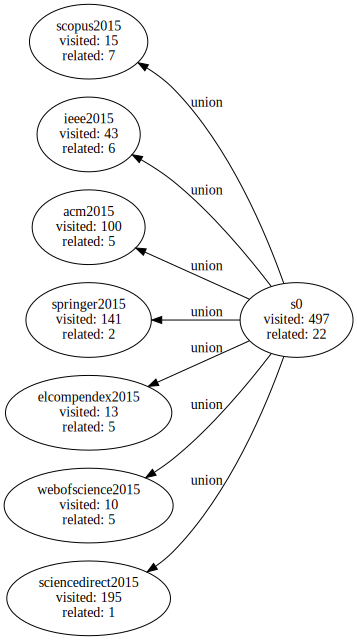

In [36]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
#strategy.initial.find("acm")
strategy.initial



In [37]:
array = []

print ("--- Estratégia 1 (E1) ---")
name = "E1"
EP = (len (strategy.initial.related) / len (strategy.initial.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (strategy.initial.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 4.4%
Recall: 43.1%
F-Measure: 8.0%


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

In [ ]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [ ]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [ ]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

In [ ]:
strategy.initial is state.find("s0")

In [ ]:
E2P = (len (strategy.initial.related) / len (strategy.initial.visited))*100

print ("--Precision--")
print ("Busca: %.1f%%" % E2P)

E2PS = (len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited))*100

print ("Snowballing: %.2f%%" % E2PS)

print("- Forward - iteração 1: %.2f%%" % ((len (state.find("s1").delta_related) / len (state.find("s1").delta_visited))*100))

print("- Backward - iteração 1: %.2f%%" % ((len (state.find("s2").delta_related) / len (state.find("s2").delta_visited))*100))

print("Precision E2 (Busca + Snowballing): %.1f%%" % ((len(state.related) / len(state.visited))*100))


print ("\n--- Estratégia 2 (E2) ---")
name = "E2"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

In [ ]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

In [ ]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

In [ ]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [ ]:
print ("--- Estratégia 3 (E3) ---")
name = "E3"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))


## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [ ]:
print ("--- Estratégia 4 (E4) ---")
name = "E4"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [ ]:
print ("--- Estratégia 5 (E5) ---")
name = "E5"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [ ]:
print ("--- Estratégia 6 (E6) ---")
name = "E6"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [ ]:
print ("--- Estratégia 7 (E7) ---")
name = "E7"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

# Análise das Estratégias

In [ ]:
%matplotlib notebook
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df


In [ ]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df